In [45]:
# 🔧 OS & env
import os
from dotenv import load_dotenv
import joblib

# 📦 Data
import pandas as pd
import numpy as np

# 🧠 Modèles
from sentence_transformers import SentenceTransformer
from transformers import (
    CamembertTokenizer,
    CamembertForSequenceClassification,
    TrainingArguments,
    Trainer
)
import torch
import evaluate

# 🧪 Modèle classique sklearn
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    f1_score,
    balanced_accuracy_score,
    log_loss,
    classification_report
)
from sklearn.preprocessing import LabelEncoder

# 🤗 Datasets
from datasets import Dataset

# 🔄 Progress bar
from tqdm.auto import tqdm
tqdm.pandas()

# 🤖 OpenAI
import openai

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    f1_score, balanced_accuracy_score, log_loss, classification_report
)
import numpy as np

import matplotlib.pyplot as plt
import requests

## Load Data

In [2]:
df = pd.read_parquet('../Data/excerpts_processed.parquet')
print(df['Author'].nunique())

28


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Author        3858 non-null   object
 1   Title         3858 non-null   object
 2   URL           3858 non-null   object
 3   Excerpt_ID    3858 non-null   object
 4   Excerpt_Text  3858 non-null   object
 5   Cleaned_Text  3858 non-null   object
 6   Tokens        3858 non-null   object
dtypes: object(7)
memory usage: 211.1+ KB


## Creating embeddings

In [6]:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

def get_openai_embedding(text: str) -> list:
    response = openai.embeddings.create(
        model="text-embedding-3-large",
        input=text
    )
    return response.data[0].embedding

In [7]:
df['embedding_openai'] = df['Cleaned_Text'].progress_apply(get_openai_embedding)

  0%|          | 0/3858 [00:00<?, ?it/s]

In [5]:
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
df['embedding_local'] = df['Cleaned_Text'].apply(lambda x: model.encode(x, normalize_embeddings=True))

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# Save the dataset with embeddings
pd.DataFrame(df, columns=['Author', 'embedding_openai', 'embedding_local']).to_parquet("../Data/excerpts_embeddings.parquet")

In [13]:
df[['embedding_openai', 'embedding_local']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3858 entries, 0 to 3857
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   embedding_openai  3858 non-null   object
 1   embedding_local   3858 non-null   object
dtypes: object(2)
memory usage: 60.4+ KB


In [ ]:
df[['embedding_openai', 'embedding_local']].head()

,embedding_openai,embedding_local
0,"[0.048153895884752274, -0.017010046169161797, ...","[0.090957664, 0.1280141, 0.09524013, 0.0497254..."
1,"[0.023386938497424126, -0.00011565632303245366...","[0.028971776, 0.10148306, 0.075662315, 0.01602..."
2,"[0.02694179303944111, -0.006567550357431173, -...","[0.024064457, 0.12908925, -0.04069711, 0.03864..."
3,"[0.033149126917123795, -0.007655735593289137, ...","[0.06616951, 0.041626986, 0.046035066, -0.0459..."
4,"[0.03746573254466057, -0.016904247924685478, -...","[0.06634917, 0.05733555, 0.051622298, 0.104275..."


In [22]:
len(df['embedding_openai'][0])

3072

In [23]:
len(df['embedding_local'][0])

384

## Training classifiers

### MLP vs log reg and SVM

In [59]:
def evaluate_models(X, y, test_size=0.2, random_state=42):
    X = np.array(X.tolist())  # Si X est un DataFrame de colonnes vectorisées

    # Split train/test stratifié
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=random_state
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    models = {
        "LogisticRegression": {
            "model": LogisticRegression(max_iter=1000),
            "params": {
                "estimator__C": [0.1, 0.5, 1, 10]
            }
        },
        "SVM": {
            "model": SVC(probability=True),
            "params": {
                "estimator__C": [0.1, 0.5, 1],
                "estimator__kernel": ["linear", "rbf", "poly"]
            }
        },
        "MLP": {
            "model": MLPClassifier(max_iter=500),
            "params": {
                "estimator__hidden_layer_sizes": [(100,), (100, 50)],
                "estimator__alpha": [1e-4, 1e-3]
            }
        }
    }

    best_result = None
    all_results = []

    for name, cfg in models.items():
        print(f"\n🔍 Tuning {name}...")

        clf = OneVsRestClassifier(cfg["model"])
        grid = GridSearchCV(
            estimator=clf,
            param_grid=cfg["params"],
            scoring="f1_macro",
            cv=cv,
            n_jobs=-1
        )
        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test)

        result = {
            "model_name": name,
            "best_estimator": grid.best_estimator_,
            "best_params": grid.best_params_,
            "f1_macro": f1_score(y_test, y_pred, average='macro'),
            "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
            "log_loss": log_loss(y_test, y_proba),
            "classification_report": classification_report(y_test, y_pred, zero_division=0)
        }

        all_results.append(result)

        if best_result is None or result["f1_macro"] > best_result["f1_macro"]:
            best_result = result

    return best_result, all_results


In [60]:
best_result, all_results = evaluate_models(df['embedding_openai'], df['Author'])


🔍 Tuning LogisticRegression...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the envir


🔍 Tuning SVM...

🔍 Tuning MLP...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [61]:
print(f"\n✅ Meilleur modèle : {best_result['model_name']}")
print(f"Paramètres : {best_result['best_params']}")
print(f"F1_macro : {best_result['f1_macro']:.4f}")
print(f"Balanced accuracy : {best_result['balanced_accuracy']:.4f}")
print(f"Log loss : {best_result['log_loss']:.4f}")
print("\nClassification report :\n", best_result['classification_report'])


✅ Meilleur modèle : MLP
Paramètres : {'estimator__alpha': 0.001, 'estimator__hidden_layer_sizes': (100, 50)}
F1_macro : 0.9757
Balanced accuracy : 0.9742
Log loss : 0.1199

Classification report :
                       precision    recall  f1-score   support

      Alain-Fournier       1.00      1.00      1.00         7
     Alexandre Dumas       0.97      0.95      0.96        40
     Alfred de Vigny       0.96      0.92      0.94        24
     Alphonse Daudet       0.97      1.00      0.99        37
      Anatole France       0.95      0.97      0.96        36
          André Gide       1.00      1.00      1.00        15
      Charles Nodier       1.00      1.00      1.00         8
    François Mauriac       1.00      1.00      1.00        11
         George Sand       0.92      0.88      0.90        40
    Georges Bernanos       1.00      0.92      0.96        12
    Gustave Flaubert       1.00      1.00      1.00        37
   Guy de Maupassant       1.00      0.85      0.92     

In [62]:
best_result, all_results = evaluate_models(df['embedding_local'], df['Author'])


🔍 Tuning LogisticRegression...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


🔍 Tuning SVM...

🔍 Tuning MLP...


In [63]:
print(f"\n✅ Meilleur modèle : {best_result['model_name']}")
print(f"Paramètres : {best_result['best_params']}")
print(f"F1_macro : {best_result['f1_macro']:.4f}")
print(f"Balanced accuracy : {best_result['balanced_accuracy']:.4f}")
print(f"Log loss : {best_result['log_loss']:.4f}")
print("\nClassification report :\n", best_result['classification_report'])


✅ Meilleur modèle : SVM
Paramètres : {'estimator__C': 1, 'estimator__kernel': 'rbf'}
F1_macro : 0.3407
Balanced accuracy : 0.3496
Log loss : 2.3128

Classification report :
                       precision    recall  f1-score   support

      Alain-Fournier       0.00      0.00      0.00         7
     Alexandre Dumas       0.28      0.25      0.26        40
     Alfred de Vigny       0.47      0.33      0.39        24
     Alphonse Daudet       0.44      0.30      0.35        37
      Anatole France       0.27      0.33      0.30        36
          André Gide       0.42      0.33      0.37        15
      Charles Nodier       0.40      0.25      0.31         8
    François Mauriac       0.60      0.27      0.38        11
         George Sand       0.28      0.12      0.17        40
    Georges Bernanos       0.27      0.25      0.26        12
    Gustave Flaubert       0.29      0.32      0.30        37
   Guy de Maupassant       0.16      0.12      0.13        26
      Henri Barbus

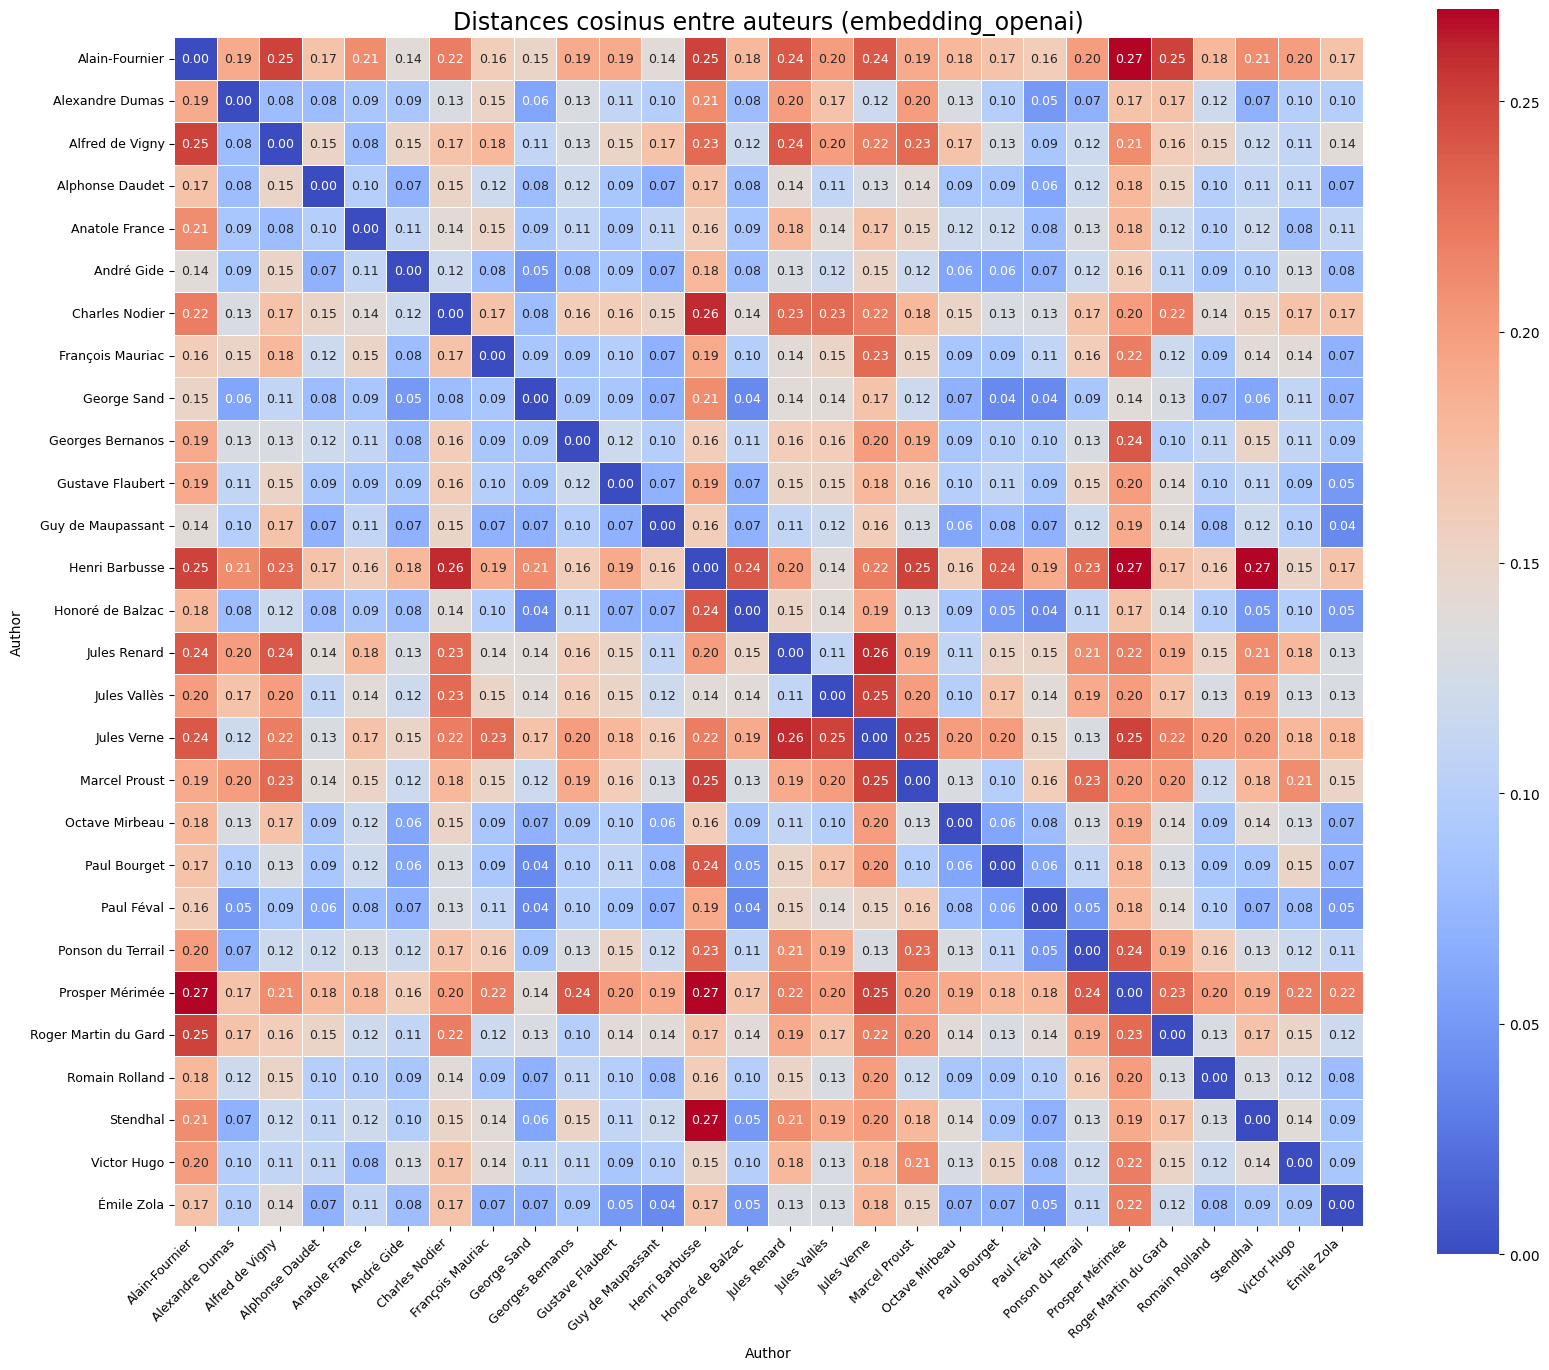


📘 Auteurs avec distance cosinus < 0.05 :
 - Honoré de Balzac <> Paul Féval : 0.039
 - George Sand <> Honoré de Balzac : 0.041
 - George Sand <> Paul Bourget : 0.044
 - George Sand <> Paul Féval : 0.044
 - Guy de Maupassant <> Émile Zola : 0.044

⚠️ Auteurs avec distance cosinus > 0.20 :
 - Henri Barbusse <> Stendhal : 0.273
 - Henri Barbusse <> Prosper Mérimée : 0.271
 - Alain-Fournier <> Prosper Mérimée : 0.266
 - Charles Nodier <> Henri Barbusse : 0.264
 - Jules Renard <> Jules Verne : 0.264
 - Alain-Fournier <> Henri Barbusse : 0.254
 - Jules Verne <> Prosper Mérimée : 0.251
 - Henri Barbusse <> Marcel Proust : 0.25
 - Jules Verne <> Marcel Proust : 0.249
 - Alain-Fournier <> Alfred de Vigny : 0.246
 - Alain-Fournier <> Roger Martin du Gard : 0.246
 - Jules Vallès <> Jules Verne : 0.246
 - Ponson du Terrail <> Prosper Mérimée : 0.241
 - Alfred de Vigny <> Jules Renard : 0.239
 - Alain-Fournier <> Jules Renard : 0.238
 - Alain-Fournier <> Jules Verne : 0.238
 - Georges Bernanos <> P

In [70]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn as sns

# ----------- 1. Extraire les embeddings par auteur -----------
# On suppose que chaque ligne est un document avec un embedding
# Moyenne des embeddings par auteur
df['embedding_array'] = df['embedding_openai'].apply(np.array)
df_mean = df.groupby('Author')['embedding_array'].apply(lambda x: np.mean(x.tolist(), axis=0))

# ----------- 2. Matrice des distances cosinus -----------
dist_matrix = pd.DataFrame(
    cosine_distances(list(df_mean)),
    index=df_mean.index,
    columns=df_mean.index
)

# ----------- 3. Affichage heatmap -----------
plt.figure(figsize=(len(df_mean) * 0.6, len(df_mean) * 0.5))
sns.heatmap(
    dist_matrix.round(2),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    annot_kws={"size": 9},
    linewidths=0.5,
    linecolor='white',
    square=True
)
plt.title("Distances cosinus entre auteurs (embedding_openai)", fontsize=17)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# ----------- 4. Paires les plus proches / lointaines -----------
close_pairs = []
far_pairs = []

for i in range(len(dist_matrix)):
    for j in range(i + 1, len(dist_matrix)):
        dist = dist_matrix.iloc[i, j]
        a1 = dist_matrix.index[i]
        a2 = dist_matrix.columns[j]
        if dist < 0.05:
            close_pairs.append((a1, a2, round(dist, 3)))
        elif dist > 0.20:
            far_pairs.append((a1, a2, round(dist, 3)))

# Affichage
print("\n📘 Auteurs avec distance cosinus < 0.05 :")
if close_pairs:
    for a1, a2, d in sorted(close_pairs, key=lambda x: x[2]):
        print(f" - {a1} <> {a2} : {d}")
else:
    print("Aucune paire proche.")

print("\n⚠️ Auteurs avec distance cosinus > 0.20 :")
if far_pairs:
    for a1, a2, d in sorted(far_pairs, key=lambda x: x[2], reverse=True):
        print(f" - {a1} <> {a2} : {d}")
else:
    print("Aucune paire lointaine.")


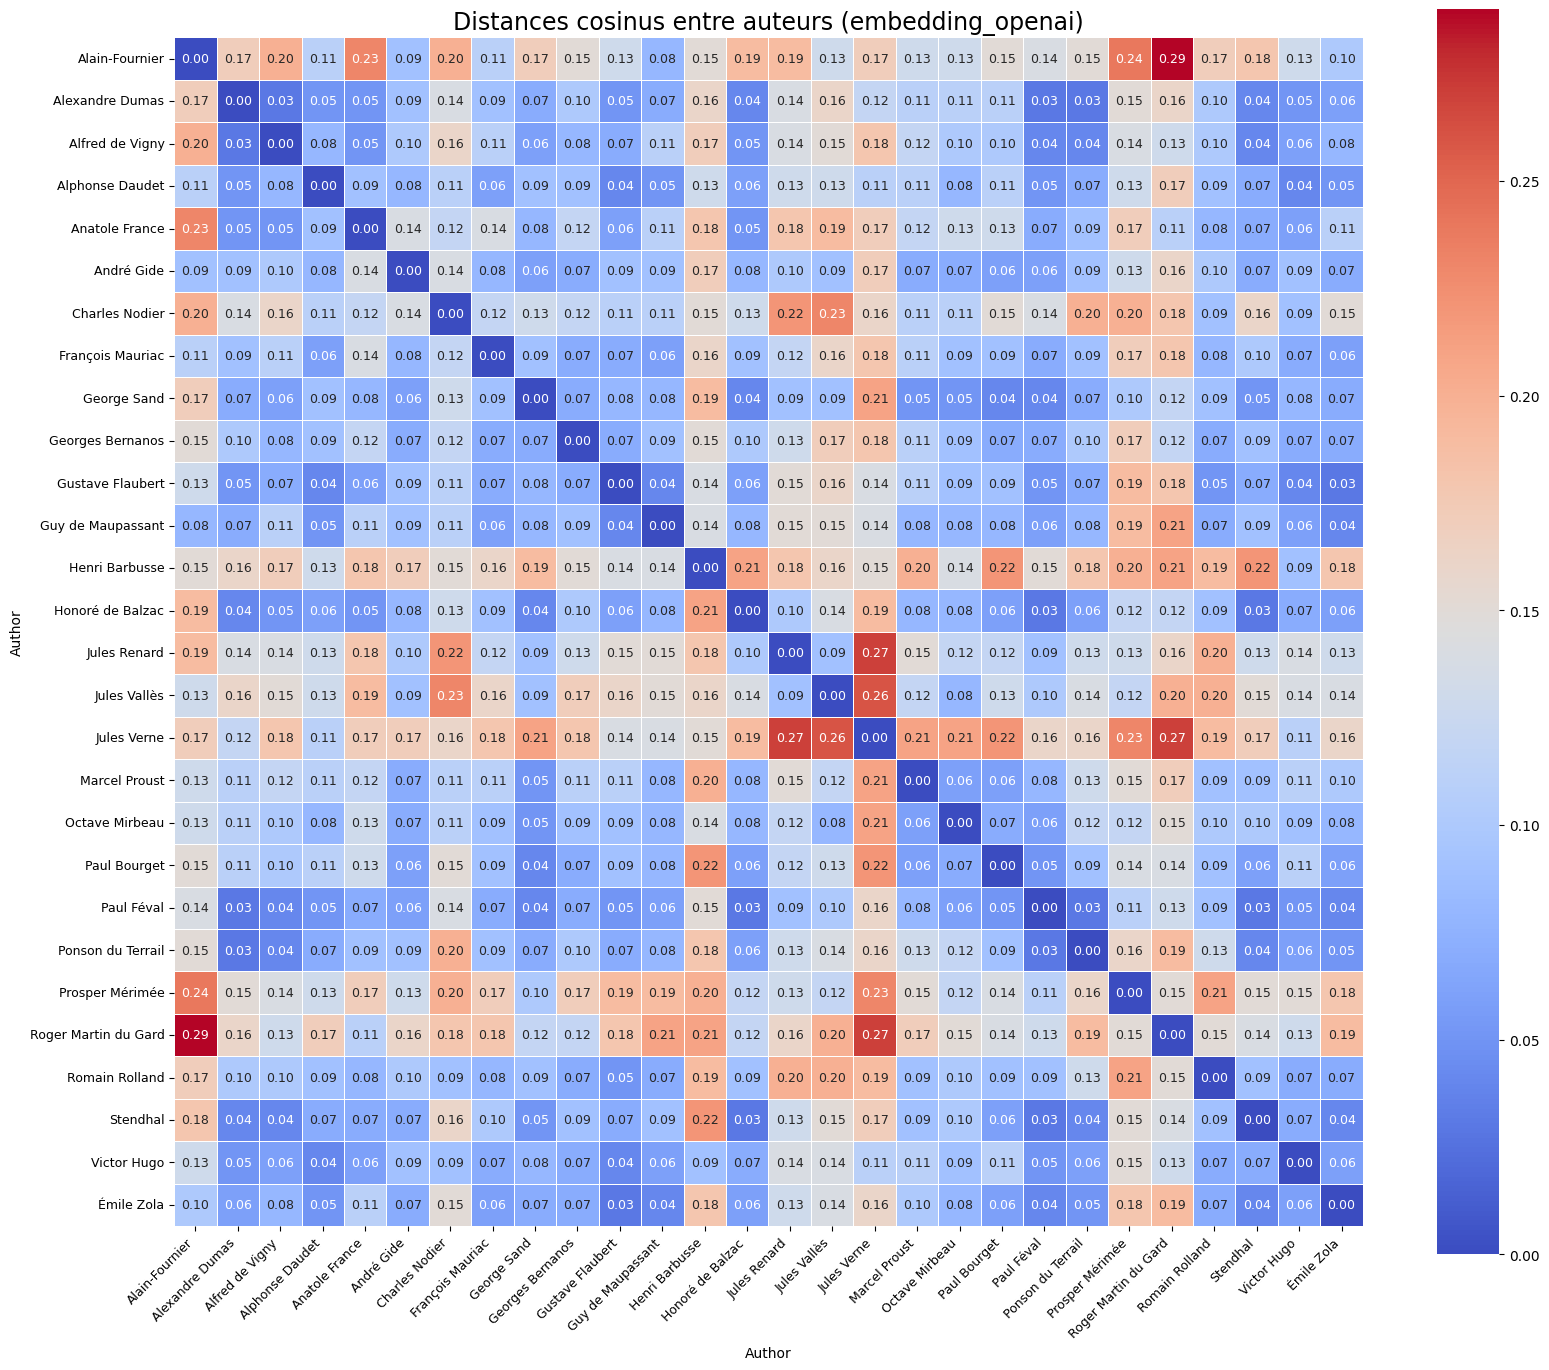


📘 Auteurs avec distance cosinus < 0.05 :
 - Honoré de Balzac <> Paul Féval : 0.027000000700354576
 - Honoré de Balzac <> Stendhal : 0.02800000086426735
 - Alexandre Dumas <> Alfred de Vigny : 0.03099999949336052
 - Paul Féval <> Ponson du Terrail : 0.03099999949336052
 - Gustave Flaubert <> Émile Zola : 0.032999999821186066
 - Alexandre Dumas <> Paul Féval : 0.03400000184774399
 - Paul Féval <> Stendhal : 0.03400000184774399
 - Alexandre Dumas <> Ponson du Terrail : 0.03500000014901161
 - George Sand <> Paul Féval : 0.03500000014901161
 - Alphonse Daudet <> Victor Hugo : 0.035999998450279236
 - Guy de Maupassant <> Émile Zola : 0.035999998450279236
 - Alexandre Dumas <> Stendhal : 0.039000000804662704
 - George Sand <> Honoré de Balzac : 0.039000000804662704
 - Alfred de Vigny <> Paul Féval : 0.03999999910593033
 - Alfred de Vigny <> Stendhal : 0.03999999910593033
 - Paul Féval <> Émile Zola : 0.03999999910593033
 - Alphonse Daudet <> Gustave Flaubert : 0.04100000113248825
 - George S

In [71]:
# ----------- 1. Extraire les embeddings par auteur -----------
# On suppose que chaque ligne est un document avec un embedding
# Moyenne des embeddings par auteur
df['embedding_array'] = df['embedding_local'].apply(np.array)
df_mean = df.groupby('Author')['embedding_array'].apply(lambda x: np.mean(x.tolist(), axis=0))

# ----------- 2. Matrice des distances cosinus -----------
dist_matrix = pd.DataFrame(
    cosine_distances(list(df_mean)),
    index=df_mean.index,
    columns=df_mean.index
)

# ----------- 3. Affichage heatmap -----------
plt.figure(figsize=(len(df_mean) * 0.6, len(df_mean) * 0.5))
sns.heatmap(
    dist_matrix.round(2),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    annot_kws={"size": 9},
    linewidths=0.5,
    linecolor='white',
    square=True
)
plt.title("Distances cosinus entre auteurs (embedding_openai)", fontsize=17)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# ----------- 4. Paires les plus proches / lointaines -----------
close_pairs = []
far_pairs = []

for i in range(len(dist_matrix)):
    for j in range(i + 1, len(dist_matrix)):
        dist = dist_matrix.iloc[i, j]
        a1 = dist_matrix.index[i]
        a2 = dist_matrix.columns[j]
        if dist < 0.05:
            close_pairs.append((a1, a2, round(dist, 3)))
        elif dist > 0.20:
            far_pairs.append((a1, a2, round(dist, 3)))

# Affichage
print("\n📘 Auteurs avec distance cosinus < 0.05 :")
if close_pairs:
    for a1, a2, d in sorted(close_pairs, key=lambda x: x[2]):
        print(f" - {a1} <> {a2} : {d}")
else:
    print("Aucune paire proche.")

print("\n⚠️ Auteurs avec distance cosinus > 0.20 :")
if far_pairs:
    for a1, a2, d in sorted(far_pairs, key=lambda x: x[2], reverse=True):
        print(f" - {a1} <> {a2} : {d}")
else:
    print("Aucune paire lointaine.")


## Testing the capacity of an LLM for author classification

In [34]:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

authors = df['Author'].unique().tolist()

In [35]:
def classify_with_gpt_and_fallback(text, authors):
    authors_str = ", ".join(authors)

    # Prompt principal avec GPT-4.1
    main_prompt = (
        "Tu es un expert en littérature française.\n\n"
        "On va te fournir un extrait d’un texte littéraire. Ton objectif est d’identifier son auteur parmi une liste donnée. "
        f"Tous les extraits proviennent de l’un des auteurs suivants :\n\n{authors_str}.\n\n"
        "Lis attentivement le texte, puis réponds uniquement par le **nom exact de l’auteur**, sans explication ni justification.\n\n"
        "Voici l’extrait :\n\n"
        f"{text}\n\n"
        "Qui en est l’auteur ?"
    )

    try:
        response = openai.chat.completions.create(
            model="gpt-4.1-2025-04-14",
            messages=[{"role": "user", "content": main_prompt}],
            temperature=0,
            max_tokens=50
        )
        raw_response = response.choices[0].message.content.strip()

        # Si réponse exacte, retour immédiat
        if raw_response in authors:
            return raw_response

        # Sinon, fallback avec nano pour corriger
        fallback_prompt = (
            f"La réponse suivante a été donnée : « {raw_response} ».\n"
            f"Voici la liste correcte des auteurs possibles : {authors_str}.\n\n"
            "Ton rôle est simplement de renvoyer **le nom exact** dans la liste qui correspond le mieux à cette réponse, "
            "ou 'Unknown' si aucun ne correspond. Ne réponds rien d’autre que le nom exact."
        )

        correction = openai.chat.completions.create(
            model="gpt-4.1-nano-2025-04-14",
            messages=[{"role": "user", "content": fallback_prompt}],
            temperature=0,
            max_tokens=20
        )

        return correction.choices[0].message.content.strip()

    except Exception as e:
        print("Erreur GPT:", e)
        return "Unknown"


In [36]:
df_sample, _ = train_test_split(
    df,
    test_size=0.7,           
    stratify=df["Author"],      
    random_state=42             
)

# Appliquer le classificateur GPT avec fallback
gpt_preds = []
raw_gpt_outputs = []

# Use tqdm for the progress bar
for text in tqdm(df_sample['Cleaned_Text'], desc="Classifying texts"):
    try:
        response = classify_with_gpt_and_fallback(text, authors)
        raw_gpt_outputs.append(response)
        gpt_preds.append(response if response in authors else "Unknown")
    except Exception as e:
        raw_gpt_outputs.append("Erreur")
        gpt_preds.append("Unknown")

df_sample['gpt_raw'] = raw_gpt_outputs
df_sample['gpt_pred'] = gpt_preds


Classifying texts:   0%|          | 0/1157 [00:00<?, ?it/s]

In [37]:
y_true = df_sample['Author']
y_pred = df_sample['gpt_pred']

f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
bal_acc = balanced_accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, zero_division=0)

print("✅ Évaluation GPT-4.1 avec fallback nano")
print(f"F1 macro: {f1:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print("\nClassification report:\n", report)


✅ Évaluation GPT-4.1 avec fallback nano
F1 macro: 0.8085
Balanced accuracy: 0.8471

Classification report:
                       precision    recall  f1-score   support

      Alain-Fournier       0.92      1.00      0.96        11
     Alexandre Dumas       0.78      1.00      0.87        59
     Alfred de Vigny       1.00      0.72      0.84        36
     Alphonse Daudet       0.93      1.00      0.96        55
      Anatole France       0.93      0.98      0.96        55
          André Gide       0.92      0.50      0.65        22
      Charles Nodier       0.83      0.91      0.87        11
    François Mauriac       1.00      0.47      0.64        17
         George Sand       0.86      0.97      0.91        59
    Georges Bernanos       0.88      0.83      0.86        18
    Gustave Flaubert       0.86      0.93      0.89        55
   Guy de Maupassant       0.98      1.00      0.99        40
      Henri Barbusse       1.00      0.78      0.88        23
    Honoré de Balzac   

/Users/hadrienstrichard/Library/Caches/pypoetry/virtualenvs/research-paper-9dnSQuhV-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [43]:
from sklearn.metrics import classification_report

# Générer le rapport sous forme de dictionnaire
report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

# Extraire uniquement les lignes qui sont les noms d'auteurs (éviter avg/accuracy)
author_scores = {
    author: metrics["f1-score"]
    for author, metrics in report_dict.items()
    if author not in ["accuracy", "macro avg", "weighted avg"]
}

# Convertir en DataFrame pour fusion avec authors_df
f1_df = pd.DataFrame(list(author_scores.items()), columns=["Name", "f1-score"])


In [50]:

from wikidata.client import Client


# Charger le fichier CSV
authors_df = pd.read_csv("../Data/final_authors.csv")

# Initialiser Wikidata client
client = Client()

# SPARQL pour trouver l'ID Wikidata d'un auteur
def get_wikidata_id(name):
    url = "https://www.wikidata.org/w/api.php"
    params = {
        "action": "wbsearchentities",
        "language": "fr",
        "format": "json",
        "search": name
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data["search"][0]["id"] if data["search"] else None
    except Exception as e:
        print(f"Erreur ID pour {name}: {e}")
        return None

# Récupérer le nombre de langues Wikipédia
def get_lang_count(wikidata_id):
    if not wikidata_id:
        return 0
    url = f"https://www.wikidata.org/wiki/Special:EntityData/{wikidata_id}.json"
    try:
        response = requests.get(url)
        entity = response.json()
        sitelinks = entity["entities"][wikidata_id].get("sitelinks", {})
        return len(sitelinks)
    except Exception as e:
        print(f"Erreur langues pour {wikidata_id}: {e}")
        return 0

# Appliquer aux noms
tqdm.pandas()
authors_df["WikidataID"] = authors_df["Name"].progress_apply(get_wikidata_id)
authors_df["WikiLangCount"] = authors_df["WikidataID"].progress_apply(get_lang_count)

authors_df.drop("WikidataID", axis=1, inplace=True)

# Sauvegarder le résultat dans un nouveau fichier
authors_df.to_csv("../Data/final_authors.csv", index=False)


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Index(['Name', 'birth_date', 'death_date', 'n_books', 'Mouvement', 'Genres',
       'n_excerpts', 'WikiLangCount', 'f1-score'],
      dtype='object')


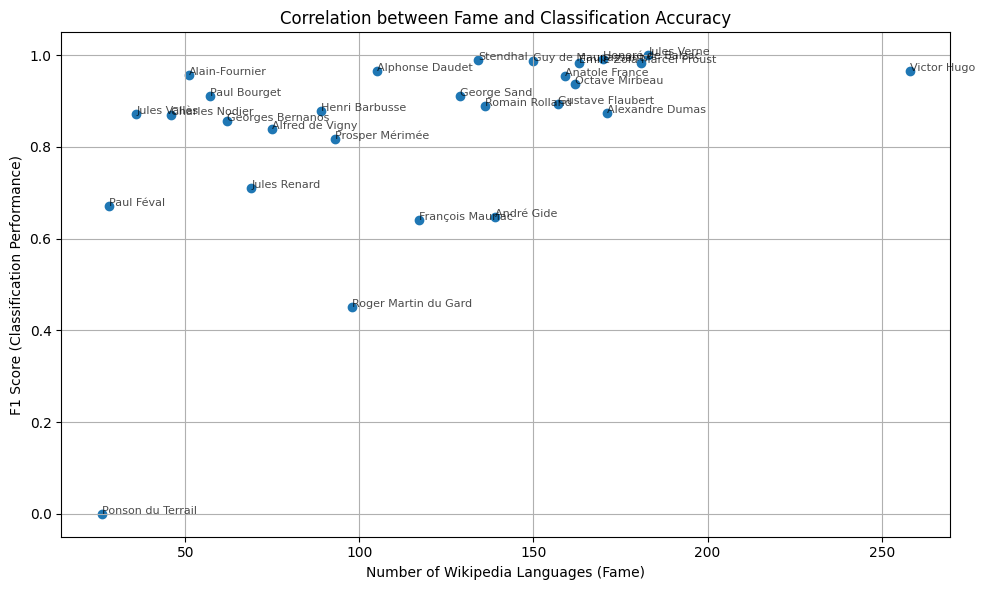

In [55]:
# Charger les données (à adapter si déjà chargé dans ton environnement)
authors_df = pd.read_csv("../Data/final_authors.csv")

# Fusion sur la colonne "Name"
authors_df = authors_df.merge(f1_df, on="Name", how="left")

authors_df = authors_df.sort_values(by="WikiLangCount", ascending=True)

# Vérifie les colonnes disponibles
print(authors_df.columns)

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.scatter(authors_df["WikiLangCount"], authors_df["f1-score"])
for i, row in authors_df.iterrows():
    plt.text(row["WikiLangCount"], row["f1-score"], row["Name"], fontsize=8, alpha=0.7)
plt.xlabel("Number of Wikipedia Languages (Fame)")
plt.ylabel("F1 Score (Classification Performance)")
plt.title("Correlation between Fame and Classification Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()
